In [13]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import numpy as np
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from collections import Counter

In [14]:
# initial image folder
image_folder = 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi de pe net\BCN20000\ISIC-images'
# crop out black background and resize
resized_images = 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi actuale\cropped-resized-300'
# split dataset into train and test
split_dataset = 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi actuale\cropped-split-dataset-300'
# augmented train images
train_images = 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi actuale\cropped-augmented-train-300-10k'
# metadata folder
metadata_folder = 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi de pe net\BCN20000/bcn20000_metadata_2024-12-04.csv'

target_size = (300, 300)

In [ ]:

def remove_black_background(image_path, target_size=(224, 224), intensity_threshold=20):
    """
    Detects and optionally crops dermoscopic images with black borders.

    Returns:
    - binary (np.array): Binarized image for contour detection.
    - cropped_resized_img (PIL.Image): Final cropped and resized image.
    - img_with_box (np.array): Original color image with bounding box drawn.
    """
    # Load image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding to create binary mask
    _, binary = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return binary, Image.open(image_path).resize(target_size), cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Select the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Compute moments and centroid
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:
        return binary, Image.open(image_path).resize(target_size), cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Fit ellipse
    if len(largest_contour) >= 5:
        ellipse = cv2.fitEllipse(largest_contour)
        (ex, ey), (major_axis, minor_axis), angle = ellipse
    else:
        return binary, Image.open(image_path).resize(target_size), cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Define bounding box
    x1 = int(cx - major_axis / 2)
    x2 = int(cx + major_axis / 2)
    y1 = int(cy - minor_axis / 2)
    y2 = int(cy + minor_axis / 2)

    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, img.shape[1]), min(y2, img.shape[0])

    # Mask for contour area
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    inside_box = gray[y1:y2, x1:x2][mask[y1:y2, x1:x2] > 0]
    outside_box = gray[(mask == 0)]

    if len(inside_box) == 0 or len(outside_box) == 0:
        return binary, Image.open(image_path).resize(target_size), cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mean_inside = np.mean(inside_box)
    mean_outside = np.mean(outside_box)

    # draw bounding box
    img_with_box = img.copy()
    cv2.rectangle(img_with_box, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    img_with_box = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)  ib

    if abs(mean_inside - mean_outside) < intensity_threshold:
        return binary, Image.open(image_path).resize(target_size), img_with_box

    # Crop and convert
    cropped_img = img[y1:y2, x1:x2]
    cropped_resized_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)).resize(target_size)

    print(f"Cropped {image_path} (intensity diff: {abs(mean_inside - mean_outside)})")
    return binary, cropped_resized_img, img_with_box

def process_folder(input_folder, output_folder, target_size=(224, 224)):
    """
    Processes all images in a folder, removes black background, and resizes them.

    Parameters:
    - input_folder (str): Path to the folder containing images.
    - output_folder (str): Path to the folder where cropped images will be saved.
    - target_size (tuple): Target size for resizing images.
    """
    os.makedirs(output_folder, exist_ok=True)
    cropped_count = 0

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  
            img_path = os.path.join(input_folder, filename)
            _, cropped_img, was_cropped = remove_black_background(img_path, target_size)
            if was_cropped:
                cropped_count += 1
            cropped_img.save(os.path.join(output_folder, filename))

    print(f"\nTotal images processed: {len(os.listdir(input_folder))}")
    print(f"Total images cropped: {cropped_count}")

def split_train_test(image_folder, output_folder, test_size=0.2):
    """
    Splits images into training and testing sets.

    Parameters:
    - image_folder (str): Path to the folder containing images.
    - output_folder (str): Path to the folder where split images will be saved.
    - test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    - train_folder, test_folder (str): Paths to the training and testing folders.
    """
    os.makedirs(os.path.join(output_folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'test'), exist_ok=True)

    # Get all image files
    all_images = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Split into train and test sets
    train_images, test_images = train_test_split(all_images, test_size=test_size, random_state=42)

    # Copy images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(image_folder, img), os.path.join(output_folder, 'train', img))
    for img in test_images:
        shutil.copy(os.path.join(image_folder, img), os.path.join(output_folder, 'test', img))

    print("Splitting into train/test sets is complete.")
    return os.path.join(output_folder, 'train'), os.path.join(output_folder, 'test')

def copy_original_images(train_image_folder, output_folder):
    """
    Copies images from a source folder to a destination folder, keeping the same file names.

    :param source_folder: Path to the source folder containing the original images.
    :param destination_folder: Path to the destination folder where images will be copied.
    """
    if not os.path.exists(train_image_folder):
        raise ValueError(f"Folder '{train_image_folder}' doesnt exist.")

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(train_image_folder):
        source_path = os.path.join(train_image_folder, filename)
        destination_path = os.path.join(output_folder, filename)
        if os.path.isfile(source_path):
            shutil.copy2(source_path, destination_path)

    print(f"Original images from '{train_image_folder}' were copied to '{output_folder}'.")

def create_diagnosis_mapping(metadata):
    """
    Creates a mapping from diagnosis to numerical labels.

    Parameters:
    - metadata (pd.DataFrame): Metadata DataFrame containing 'diagnosis'.

    Returns:
    - dict: Mapping of diagnosis to numerical labels.
    """
    return {diag: idx for idx, diag in enumerate(metadata['diagnosis'].unique())}

def create_label_dict(metadata, diagnosis_mapping, image_folder):
    """
    Creates a dictionary mapping image filenames to labels

    Parameters:
    - metadata (pd.DataFrame):DataFrame containing 'isic_id' and 'diagnosis'.
    - diagnosis_mapping (dict): dictionary with the diagnosis
    - image_folder (str): Path to the folder containing images.

    Returns:
    - dict: Mapping of {filename: class}
    """
    label_dict = {}

    for file in os.listdir(image_folder):
        if file.endswith(".jpg"):  
            isic_id = file[:12]  
            diagnosis = metadata.loc[metadata['isic_id'] == isic_id, 'diagnosis']

            if not diagnosis.empty:
                label_dict[file] = diagnosis_mapping[diagnosis.values[0]]

    return label_dict

def calculate_class_distribution(labels_dict):
    return Counter(labels_dict.values())

def augment_images(train_image_folder, metadata, diagnosis_mapping, labels_dict, output_folder, max_class_size, target_size=(224, 224)):
    """
    Augments images for minority classes to balance the dataset.

    Parameters:
    - train_image_folder (str): Path to the folder containing original images.
    - metadata (pd.DataFrame): Metadata DataFrame containing 'isic_id' and 'diagnosis'.
    - diagnosis_mapping (dict): Mapping of diagnosis to numerical labels.
    - output_folder (str): Path to the output folder where augmented images will be saved.
    - max_class_size (int): Maximum class size to balance the dataset.
    - class_distribution (Counter): Distribution of the classes in the train folder.
    """
    os.makedirs(output_folder, exist_ok=True)

    datagen = ImageDataGenerator(
        rescale=None,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        fill_mode='reflect')


    for cls, count in calculate_class_distribution(labels_dict).items():
        cls_name = list(diagnosis_mapping.keys())[list(diagnosis_mapping.values()).index(cls)]
        cls_ids = metadata[metadata['diagnosis'] == cls_name]['isic_id'].values

        # total_images_for_class - total number of images that need to be generated
        total_images_for_class = max_class_size - count
        images_needed = (max_class_size - count) // count + 1
        print(f"Generating {total_images_for_class} - {images_needed} files per image for class {cls} - {cls_name}.")
        if images_needed > 0 and total_images_for_class > 0:
            for img_id in cls_ids:
                if total_images_for_class <= 0:
                  break

                img_path = os.path.join(train_image_folder, f"{img_id}.jpg")
                if not os.path.exists(img_path):
                    continue

                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)

                # count for the current image
                augmented_count = 0
                for batch in datagen.flow(img_array, batch_size=1):
                    augmented_img_name = f"{img_id}_{augmented_count}.jpg"
                    augmented_img_path = os.path.join(output_folder, augmented_img_name)
                    augmented_img = batch[0].astype('uint8')
                    augmented_img = Image.fromarray(augmented_img)
                    augmented_img.save(augmented_img_path)

                    augmented_count += 1
                    total_images_for_class -= 1
                    # if we reached the number of augmentations required for the current image
                    if augmented_count >= images_needed:
                        break
                    # if we reached the number of augmentations required for this class
                    if total_images_for_class == 0:
                        break


Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi de pe net\BCN20000\ISIC-images\ISIC_0053489.jpg (intensity diff: 154.8542873581113)


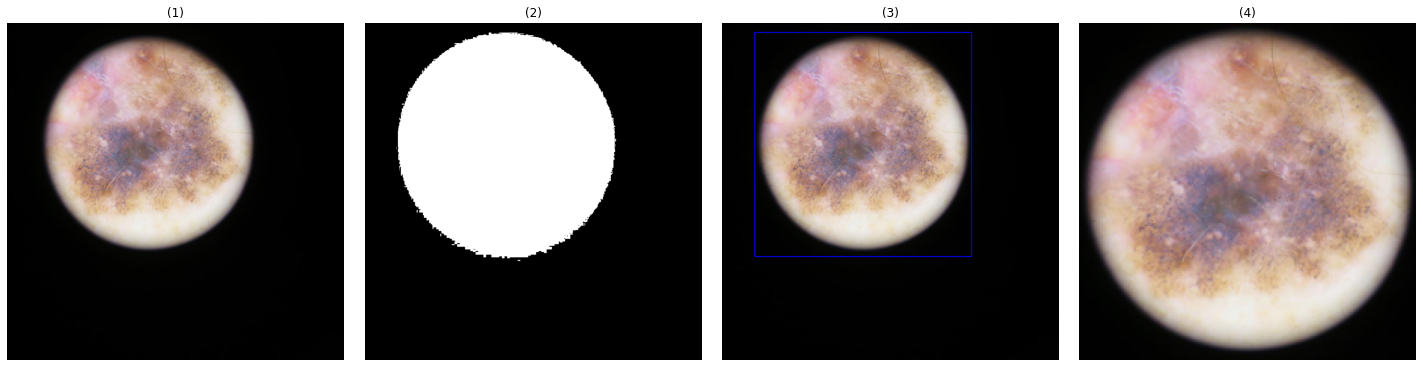

In [ ]:
image_path = os.path.join(image_folder, "ISIC_0053489.jpg")

binary, cropped_image, img_with_box = remove_black_background(image_path)

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(Image.open(image_path))
plt.title("(1)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("(2)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB))
plt.title("(3)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cropped_image)
plt.title("(4)")
plt.axis("off")

plt.tight_layout()
plt.show()

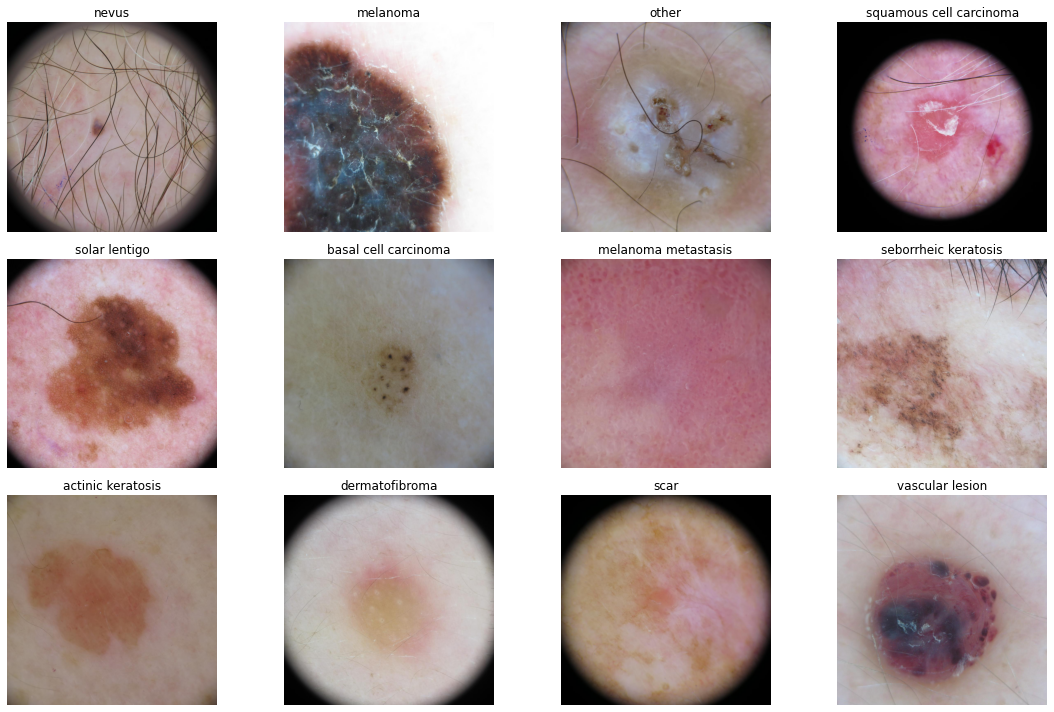

In [16]:
metadata = pd.read_csv(metadata_folder)
diagnosis_mapping = create_diagnosis_mapping(metadata)
# --- Plot images in 3x4 grid ---
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, (diagnosis, cls_index) in enumerate(diagnosis_mapping.items()):
    if i >= 12:
        break  # limit to 12 classes for a 3x4 grid

    # Find one image for this diagnosis
    matching_rows = metadata[metadata["diagnosis"] == diagnosis]
    if matching_rows.empty:
        axes[i].set_title(f"{diagnosis} (no image)")
        axes[i].axis("off")
        continue

    image_id = matching_rows.iloc[0]["isic_id"]
    image_path = os.path.join(image_folder, f"{image_id}.jpg")

    # Plot image if available
    if os.path.exists(image_path):
        img = Image.open(image_path).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"{diagnosis}")
    else:
        axes[i].set_title(f"{diagnosis}\n(Image not found)")

    axes[i].axis("off")

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [5]:
# Step 1: crop and resize images
process_folder(image_folder, resized_images, target_size)

Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053453.jpg (intensity diff: 129.67967224030195)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053457.jpg (intensity diff: 138.6792591610256)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053458.jpg (intensity diff: 131.86145068643532)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053460.jpg (intensity diff: 137.49027831350625)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053461.jpg (intensity diff: 134.118503038816)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053462.jpg (intensity diff: 143.96931155279373)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053464.jpg (intensity diff: 168.5535391936133)
Cropped C:/Users\Miruna\Desktop\Master\Dizertatie\BCN20000\ISIC-images\ISIC_0053469.jpg (intensity diff: 129.2965409636494)
Cropp

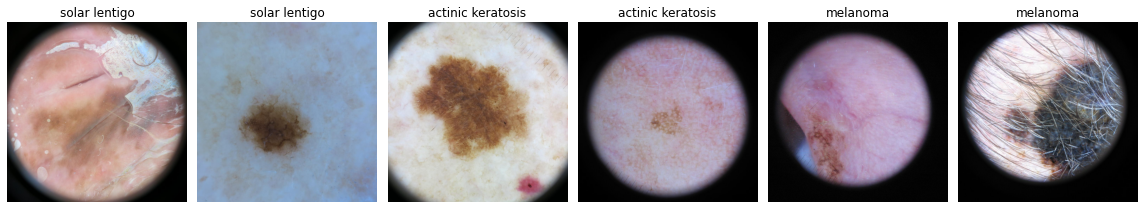

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

metadata = pd.read_csv(metadata_folder) 

target_classes = ["solar lentigo", "actinic keratosis", "melanoma"]
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
axes = axes.flatten()

img_idx = 0

for diagnosis in target_classes:
    matching_rows = metadata[metadata["diagnosis"] == diagnosis]

    num_samples = 2
    total = len(matching_rows)
    if total >= num_samples:
        start_idx = total // 2 - num_samples // 2
        selected_rows = matching_rows.iloc[start_idx : start_idx + num_samples]
    else:
        selected_rows = matching_rows

    for _, row in selected_rows.iterrows():
        if img_idx >= len(axes):
            break

        image_id = row["isic_id"]
        image_path = os.path.join(image_folder, f"{image_id}.jpg")

        if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            axes[img_idx].imshow(img)
            axes[img_idx].set_title(f"{diagnosis}")
        else:
            axes[img_idx].set_title(f"{diagnosis}\n(Image not found)")

        axes[img_idx].axis("off")
        img_idx += 1

for j in range(img_idx, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [5]:
len(os.listdir(resized_images))

18946

In [7]:
# Step 2: split into train and test
train_folder, test_folder = split_train_test(
    image_folder=resized_images,
    output_folder=split_dataset,
    test_size=0.25
)

Splitting into train/test sets is complete.


In [11]:
print('train: ', len(os.listdir(split_dataset + '/train')))
print('test: ', len(os.listdir(split_dataset + '/test')))

train:  14209
test:  4737


In [12]:
metadata = pd.read_csv(metadata_folder)
diagnosis_mapping = create_diagnosis_mapping(metadata)
train_labels = create_label_dict(metadata, diagnosis_mapping, split_dataset + '/train')
test_labels = create_label_dict(metadata, diagnosis_mapping, split_dataset + '/test')

In [13]:
train_labels

{'ISIC_0053454.jpg': 1,
 'ISIC_0053455.jpg': 2,
 'ISIC_0053457.jpg': 3,
 'ISIC_0053460.jpg': 1,
 'ISIC_0053462.jpg': 4,
 'ISIC_0053463.jpg': 5,
 'ISIC_0053464.jpg': 0,
 'ISIC_0053465.jpg': 6,
 'ISIC_0053466.jpg': 0,
 'ISIC_0053468.jpg': 2,
 'ISIC_0053469.jpg': 1,
 'ISIC_0053472.jpg': 5,
 'ISIC_0053474.jpg': 5,
 'ISIC_0053475.jpg': 3,
 'ISIC_0053477.jpg': 0,
 'ISIC_0053478.jpg': 8,
 'ISIC_0053479.jpg': 1,
 'ISIC_0053480.jpg': 0,
 'ISIC_0053481.jpg': 1,
 'ISIC_0053482.jpg': 0,
 'ISIC_0053483.jpg': 5,
 'ISIC_0053484.jpg': 4,
 'ISIC_0053487.jpg': 5,
 'ISIC_0053488.jpg': 5,
 'ISIC_0053491.jpg': 1,
 'ISIC_0053492.jpg': 1,
 'ISIC_0053494.jpg': 5,
 'ISIC_0053495.jpg': 1,
 'ISIC_0053500.jpg': 5,
 'ISIC_0053501.jpg': 5,
 'ISIC_0053502.jpg': 5,
 'ISIC_0053505.jpg': 0,
 'ISIC_0053506.jpg': 8,
 'ISIC_0053508.jpg': 1,
 'ISIC_0053509.jpg': 1,
 'ISIC_0053510.jpg': 1,
 'ISIC_0053512.jpg': 1,
 'ISIC_0053513.jpg': 1,
 'ISIC_0053515.jpg': 8,
 'ISIC_0053517.jpg': 5,
 'ISIC_0053518.jpg': 1,
 'ISIC_0053519.j

In [9]:
test_labels

{'ISIC_0053453.jpg': 0,
 'ISIC_0053456.jpg': 1,
 'ISIC_0053458.jpg': 0,
 'ISIC_0053459.jpg': 0,
 'ISIC_0053461.jpg': 2,
 'ISIC_0053467.jpg': 7,
 'ISIC_0053470.jpg': 1,
 'ISIC_0053473.jpg': 1,
 'ISIC_0053485.jpg': 1,
 'ISIC_0053486.jpg': 6,
 'ISIC_0053489.jpg': 1,
 'ISIC_0053490.jpg': 0,
 'ISIC_0053493.jpg': 0,
 'ISIC_0053497.jpg': 0,
 'ISIC_0053499.jpg': 0,
 'ISIC_0053503.jpg': 1,
 'ISIC_0053504.jpg': 5,
 'ISIC_0053507.jpg': 1,
 'ISIC_0053511.jpg': 5,
 'ISIC_0053514.jpg': 5,
 'ISIC_0053516.jpg': 3,
 'ISIC_0053529.jpg': 0,
 'ISIC_0053541.jpg': 1,
 'ISIC_0053542.jpg': 1,
 'ISIC_0053545.jpg': 1,
 'ISIC_0053551.jpg': 0,
 'ISIC_0053556.jpg': 0,
 'ISIC_0053558.jpg': 5,
 'ISIC_0053559.jpg': 5,
 'ISIC_0053560.jpg': 0,
 'ISIC_0053570.jpg': 1,
 'ISIC_0053576.jpg': 1,
 'ISIC_0053578.jpg': 1,
 'ISIC_0053581.jpg': 7,
 'ISIC_0053585.jpg': 5,
 'ISIC_0053589.jpg': 1,
 'ISIC_0053593.jpg': 3,
 'ISIC_0053594.jpg': 1,
 'ISIC_0053596.jpg': 0,
 'ISIC_0053607.jpg': 2,
 'ISIC_0053609.jpg': 0,
 'ISIC_0053610.j

In [10]:
class_distribution = calculate_class_distribution(train_labels)
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} images")

Class 1: 2983 images
Class 2: 899 images
Class 3: 407 images
Class 4: 193 images
Class 5: 2791 images
Class 0: 4200 images
Class 6: 469 images
Class 8: 816 images
Class 9: 129 images
Class 7: 960 images
Class 10: 241 images
Class 11: 121 images


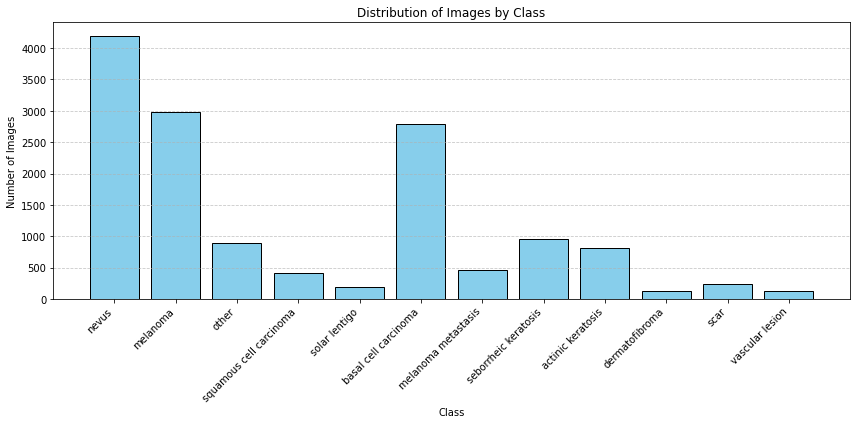

In [ ]:
reversed_mapping = {v: k for k, v in diagnosis_mapping.items()}

sorted_classes = sorted(class_distribution.keys())
sorted_counts = [class_distribution[cls] for cls in sorted_classes]
sorted_labels = [reversed_mapping[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

In [12]:
class_distribution = calculate_class_distribution(test_labels)
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} images")

Class 0: 1447 images
Class 1: 1020 images
Class 2: 257 images
Class 7: 308 images
Class 6: 164 images
Class 5: 885 images
Class 3: 152 images
Class 8: 272 images
Class 11: 30 images
Class 4: 90 images
Class 10: 73 images
Class 9: 39 images


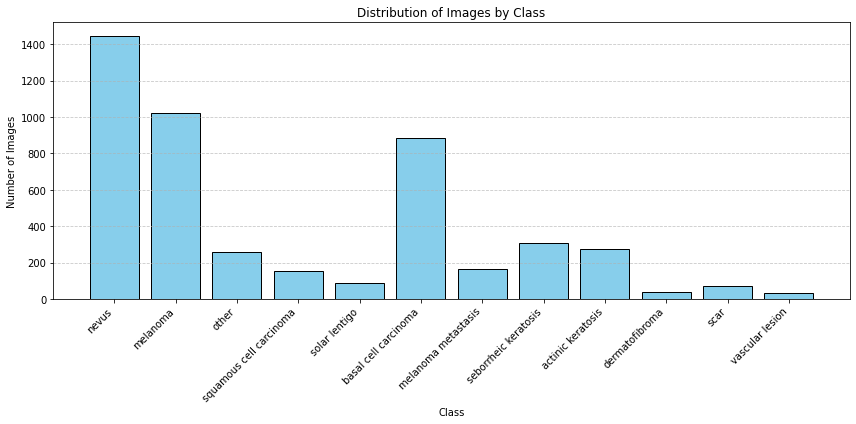

In [ ]:
reversed_mapping = {v: k for k, v in diagnosis_mapping.items()}

sorted_classes = sorted(class_distribution.keys())
sorted_counts = [class_distribution[cls] for cls in sorted_classes]
sorted_labels = [reversed_mapping[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

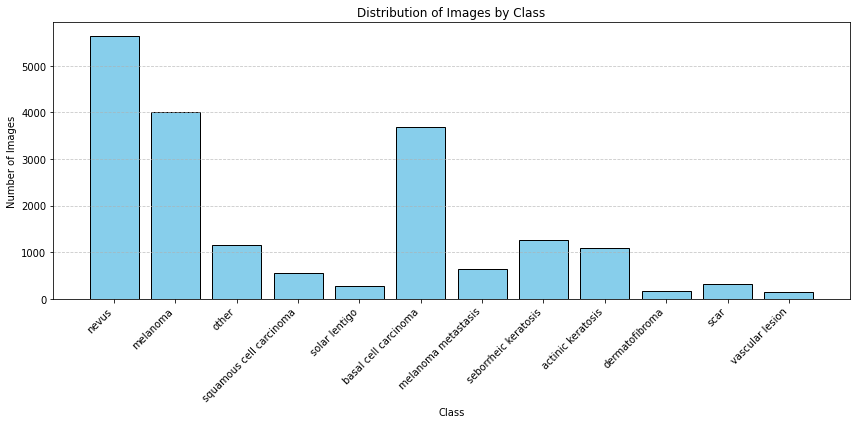

In [ ]:
metadata = pd.read_csv(metadata_folder)
diagnosis_mapping = create_diagnosis_mapping(metadata)
all_labels = create_label_dict(metadata, diagnosis_mapping, resized_images)
class_distribution = calculate_class_distribution(all_labels)

reversed_mapping = {v: k for k, v in diagnosis_mapping.items()}

sorted_classes = sorted(class_distribution.keys())
sorted_counts = [class_distribution[cls] for cls in sorted_classes]
sorted_labels = [reversed_mapping[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

In [10]:
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} images")

Class 0: 5647 images
Class 1: 4003 images
Class 2: 1156 images
Class 3: 559 images
Class 4: 283 images
Class 5: 3676 images
Class 6: 633 images
Class 7: 1268 images
Class 8: 1088 images
Class 9: 168 images
Class 10: 314 images
Class 11: 151 images


In [16]:
# Step 3: augment train images
# also manually add the initial train images into the
augment_images(split_dataset + '/train', metadata, diagnosis_mapping, train_labels, train_images, 10000, target_size)

Generating 7017 - 3 files per image for class 1 - melanoma.
Generating 9101 - 11 files per image for class 2 - other.
Generating 9593 - 24 files per image for class 3 - squamous cell carcinoma.
Generating 9807 - 51 files per image for class 4 - solar lentigo.
Generating 7209 - 3 files per image for class 5 - basal cell carcinoma.
Generating 5800 - 2 files per image for class 0 - nevus.
Generating 9531 - 21 files per image for class 6 - melanoma metastasis.
Generating 9184 - 12 files per image for class 8 - actinic keratosis.
Generating 9871 - 77 files per image for class 9 - dermatofibroma.
Generating 9040 - 10 files per image for class 7 - seborrheic keratosis.
Generating 9759 - 41 files per image for class 10 - scar.
Generating 9879 - 82 files per image for class 11 - vascular lesion.


In [17]:
copy_original_images(split_dataset + '/train', train_images)

Original images from 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi actuale\cropped-split-dataset-300/train' were copied to 'C:/Users\Miruna\Desktop\Master\Dizertatie\dataseturi actuale\cropped-augmented-train-300-10k'.


In [18]:
len(os.listdir(train_images))

120000

In [19]:
augmented_train_labels = create_label_dict(metadata, diagnosis_mapping, train_images)
class_distribution = calculate_class_distribution(augmented_train_labels)
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} images")

Class 1: 10000 images
Class 2: 10000 images
Class 3: 10000 images
Class 4: 10000 images
Class 5: 10000 images
Class 0: 10000 images
Class 6: 10000 images
Class 8: 10000 images
Class 9: 10000 images
Class 7: 10000 images
Class 10: 10000 images
Class 11: 10000 images


In [17]:
augmented_train_labels

{'ISIC_0053454.jpg': 1,
 'ISIC_0053454_0.jpg': 1,
 'ISIC_0053455.jpg': 2,
 'ISIC_0053455_0.jpg': 2,
 'ISIC_0053455_1.jpg': 2,
 'ISIC_0053455_2.jpg': 2,
 'ISIC_0053455_3.jpg': 2,
 'ISIC_0053455_4.jpg': 2,
 'ISIC_0053457.jpg': 3,
 'ISIC_0053457_0.jpg': 3,
 'ISIC_0053457_1.jpg': 3,
 'ISIC_0053457_10.jpg': 3,
 'ISIC_0053457_2.jpg': 3,
 'ISIC_0053457_3.jpg': 3,
 'ISIC_0053457_4.jpg': 3,
 'ISIC_0053457_5.jpg': 3,
 'ISIC_0053457_6.jpg': 3,
 'ISIC_0053457_7.jpg': 3,
 'ISIC_0053457_8.jpg': 3,
 'ISIC_0053457_9.jpg': 3,
 'ISIC_0053460.jpg': 1,
 'ISIC_0053460_0.jpg': 1,
 'ISIC_0053462.jpg': 4,
 'ISIC_0053462_0.jpg': 4,
 'ISIC_0053462_1.jpg': 4,
 'ISIC_0053462_10.jpg': 4,
 'ISIC_0053462_11.jpg': 4,
 'ISIC_0053462_12.jpg': 4,
 'ISIC_0053462_13.jpg': 4,
 'ISIC_0053462_14.jpg': 4,
 'ISIC_0053462_15.jpg': 4,
 'ISIC_0053462_16.jpg': 4,
 'ISIC_0053462_17.jpg': 4,
 'ISIC_0053462_18.jpg': 4,
 'ISIC_0053462_19.jpg': 4,
 'ISIC_0053462_2.jpg': 4,
 'ISIC_0053462_20.jpg': 4,
 'ISIC_0053462_21.jpg': 4,
 'ISIC_00

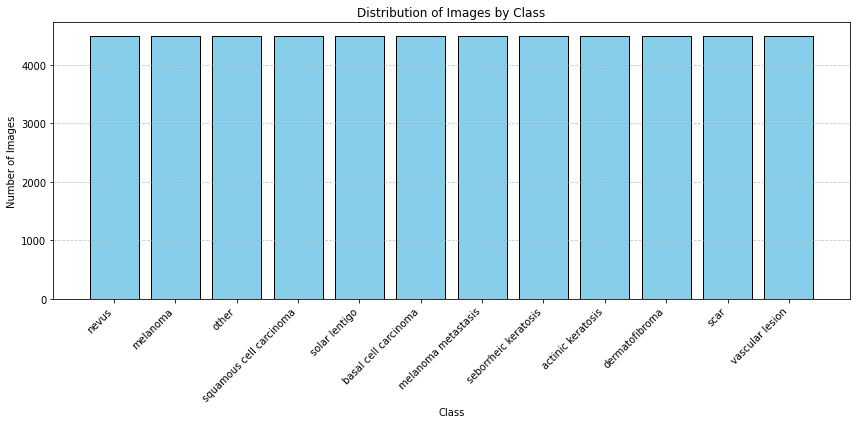

In [ ]:
reversed_mapping = {v: k for k, v in diagnosis_mapping.items()}

sorted_classes = sorted(class_distribution.keys())
sorted_counts = [class_distribution[cls] for cls in sorted_classes]
sorted_labels = [reversed_mapping[cls] for cls in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(sorted_labels, sorted_counts, color='skyblue', edgecolor='black')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Images by Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

In [19]:
diagnosis_mapping

{'nevus': 0,
 'melanoma': 1,
 'other': 2,
 'squamous cell carcinoma': 3,
 'solar lentigo': 4,
 'basal cell carcinoma': 5,
 'melanoma metastasis': 6,
 'seborrheic keratosis': 7,
 'actinic keratosis': 8,
 'dermatofibroma': 9,
 'scar': 10,
 'vascular lesion': 11}